# Evaluating PPLS Generated Texts

This notebook evaluates the generated plain language summaries (PLS) using a different dataset selected by one of the coauthors. The goal is to have professionals in Health Literacy evaluate the generated texts. We will use BERTScore and other metrics to assess the quality of the summaries.

In [1]:
import requests
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import openai
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from evaluate import load

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We read the test dataset from an Excel file located in the specified directory. This dataset contains the text samples that will be used for generating plain language summaries (PLS).

In [4]:
# Define the link for prediction (not used in this step but provided for context)
link = "http://localhost:8000/comment/predict/model_gb"

# Read the Excel file containing the test dataset
df = pd.read_excel("PPLS/Clinical Trials_Test_Dataset.xlsx", sheet_name="Text Sample")

df

,StudyID,Text,PL,Count Words,Min Count,GPTTest
0,NCT00310388,"Title: A Multicenter, Open-Label, Long-Term, S...",0,4470,Ok,NaN
1,NCT01704287,Title: A Phase III Randomized Trial of MK-3475...,0,3981,Ok,NaN
2,NCT01704287,"Indication of the Study: Head and Neck Cancer,...",0,1560,Ok,NaN
3,NCT01704287,Study Rationale: Head and neck cancer describe...,0,1225,Ok,NaN
4,NCT02054806,Title: A Phase 3 Clinical Trial of Pembrolizum...,0,5480,Ok,NaN
...,...,...,...,...,...,...
109,NCT03557281,Title: A Phase IIa Open-label Trial to Investi...,0,622,Ok,NaN
110,NCT03557281,"Indication of the Study: Tuberculosis, Inclusi...",0,632,Ok,NaN
111,NCT03557281,Study Rationale: This trial seeks to establish...,0,947,Ok,NaN
112,NCT03557281,Title: A Phase IIa Open-label Trial to Investi...,0,2199,Ok,Y


We prepare the dataset by selecting relevant columns and renaming them for clarity. The selected columns include the text samples and their corresponding labels.

In [6]:
# Select relevant columns
df = df[['Text', 'PL', 'GPTTest']]

# Rename the columns for clarity
df = df.rename(columns={'Text': 'text', 'PL': 'label'})

# Display the updated dataset
df

,text,label,GPTTest
0,"Title: A Multicenter, Open-Label, Long-Term, S...",0,NaN
1,Title: A Phase III Randomized Trial of MK-3475...,0,NaN
2,"Indication of the Study: Head and Neck Cancer,...",0,NaN
3,Study Rationale: Head and neck cancer describe...,0,NaN
4,Title: A Phase 3 Clinical Trial of Pembrolizum...,0,NaN
...,...,...,...
109,Title: A Phase IIa Open-label Trial to Investi...,0,NaN
110,"Indication of the Study: Tuberculosis, Inclusi...",0,NaN
111,Study Rationale: This trial seeks to establish...,0,NaN
112,Title: A Phase IIa Open-label Trial to Investi...,0,Y


Firstly, we check the texts using the [API](https://github.com/feliperussi/health-literacy-api-backend)

In [9]:
responses = []

# Iterate through each text sample in the dataset
for text in df['text']:
    # Send a POST request with the text sample to the prediction endpoint
    r = requests.post(link, json={"text": text})
    
    # Append the response to the list
    responses.append(r.json())
    
    # Print the prediction from each response
    print(r.json()['prediction'])


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
1
1
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
1
0
0
0
1
1
1
0
0
0
0
0
1
0
1
0
0
0
0
1


In [12]:
true_labels = df['label'].tolist()
print(len(true_labels))

114

In [13]:
predictions = []

for i in range(len(responses)):
    predictions.append(int(responses[i]['prediction']))

In [14]:
len(predictions)

114

## Evaluating Texts

We evaluate the test dataset aforementioned to see how it fits our models.

In [15]:
# Calculate the accuracy of the model
accuracy = accuracy_score(true_labels, predictions)

# Calculate the precision of the model
precision = precision_score(true_labels, predictions)

# Calculate the recall of the model
recall = recall_score(true_labels, predictions)

# Calculate the F1 score of the model
f1 = f1_score(true_labels, predictions)

# Print the evaluation metrics
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1: ", f1)

Accuracy:  0.9649122807017544
Precision:  0.7647058823529411
Recall:  1.0
F1:  0.8666666666666667


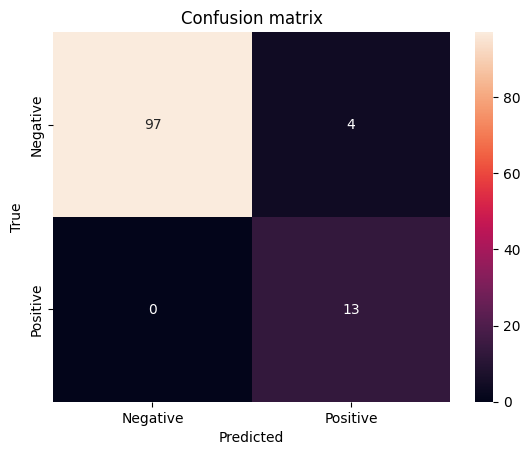

In [16]:
# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Create a heatmap to visualize the confusion matrix
sns.heatmap(cm, annot=True, fmt='g', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])

plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [17]:
scores_no_plain = []
scores_plain = []

for i in range(len(responses)):
    scores_no_plain.append(responses[i]['score_no_plain'])
    scores_plain.append(responses[i]['score_plain'])

In [20]:
# Initialize an empty list to store the indices of false positives
FP = []

# Iterate through the predictions and true labels
for i in range(len(predictions)):
    # Append the index to the list if the prediction is positive (1) and the true label is negative (0)
    if predictions[i] == 1 and true_labels[i] == 0:
        FP.append(i)

# Display the indices of false positives
FP

[36, 54, 77, 100]

Once we see how the models fit, we proceed to generate texts with LLMs and evaluate them.

## Filtering and Saving Ground Truth Texts

We filter the dataset to include only the rows where the "GPTTest" column is "Y". We then separate the texts into plain and non-plain categories and save the plain texts as ground truth in the specified folder.

### Steps:
1. Filter the dataset to include only rows where "GPTTest" is "Y".
2. Separate the dataset into plain and non-plain texts based on the "label" column.
3. Save the plain texts into the "ground_truth" folder.

In [18]:
# Filter the dataset to include only rows where "GPTTest" is "Y"
df = df[df["GPTTest"] == "Y"]

# Separate the dataset into plain and non-plain texts
df_no_plain = df[df["label"] == 0]
df_plain = df[df["label"] == 1]

# Define the folder path to save the ground truth texts
folder_path_ground_truth = "PPLS/ground_truth"

# Save the plain texts as ground truth in the specified folder
for i in range(len(df_plain)):
    with open(folder_path_ground_truth + "/" + str(i) + ".txt", 'w', encoding="utf-8") as f:
        f.write(df_plain.iloc[i]['text'])

In [85]:
df_plain

,StudyID,Text,PL,Count Words,Min Count,GPTTest
17,NCT02446899,Efficacy and Safety of Anifrolumab Compared to...,1,616,Ok,Y
22,NCT02446912,A study to find out if anifrolumab reduces lup...,1,662,Ok,Y
37,NCT02794285,Long Term Safety of Anifrolumab in Adult Subje...,1,669,Ok,Y
52,NCT03084471,"An Open-Label, Multi-Centre, Study to Assess t...",1,474,Ok,Y
86,NCT03980483,A study to assess the effectiveness and safety...,1,461,Ok,Y
94,NCT04376684,A study to learn about the effect of otilimab ...,1,598,Ok,Y
106,NTC04428333,A study to compare the effects of feladilimab ...,1,613,Ok,Y
108,NCT02821416,A study to find out how benralizumab works in ...,1,677,Ok,Y
113,NCT03557281,"An early bactericidal activity, safety and tol...",1,595,Ok,Y


In [86]:
df_no_plain

,StudyID,Text,PL,Count Words,Min Count,GPTTest
16,NCT02446899,"Title: A Multicentre, Randomised, Double-blind...",0,2937,Ok,Y
21,NCT02446912,"Title: A Multicentre, Randomised, Double-blind...",0,4958,Ok,Y
41,NCT02794285,"Title: A Multicentre, Randomised, Double-blind...",0,2691,Ok,Y
51,NCT03084471,"Title: An Open-Label, Multi-Centre, Safety Stu...",0,3049,Ok,Y
85,NCT03980483,"Title: A 52-week, Phase 3, Multicentre, Random...",0,2446,Ok,Y
93,NCT04376684,"Title: A Randomized, Double-blind, Placebo-con...",0,2104,Ok,Y
105,NTC04428333,"Title: A Randomized, Double-Blind, Adaptive, P...",0,3356,Ok,Y
107,NCT02821416,"Title: A Double-Blind, Randomized, Parallel Gr...",0,4011,Ok,Y
112,NCT03557281,Title: A Phase IIa Open-label Trial to Investi...,0,2199,Ok,Y


We configure the OpenAI API with the necessary environment variables for authentication and specify the API details. This setup is required to generate plain language summaries using the GPT-4.

In [88]:
# Set the environment variables for the API key and base URL
os.environ["OPENAI_API_BASE"] = ""
os.environ["OPENAI_API_KEY"] = ""

# Configure the OpenAI API with the specified settings
openai.api_key = os.getenv("OPENAI_API_KEY")
openai.api_base = os.getenv("OPENAI_API_BASE") # your endpoint should look like the following https://YOUR_RESOURCE_NAME.openai.azure.com/
openai.api_type = 'azure'
openai.api_version = '2023-05-15' # this may change in the future

We prepare the text data by extracting the plain and original texts from the filtered dataset. These texts will be used as input for generating plain language summaries.

In [100]:
# Extract the plain texts from the filtered dataset
texts_no_plain = df_plain["Text"].values

# Extract the original texts from the filtered dataset
texts_original = df_plain["Text"].values

## Generating Protocol Plain Language Summaries (PPLS)

We generate Protocol Plain Language Summaries (PPLS) using GPT-4 for clinical trial protocol texts. The summaries adhere to specific guidelines to ensure they are understandable by any patient, regardless of their health literacy.

In [91]:
i = 0
for text in texts:    
    prompt = f"""
Using the following clinical trial protocol text as input, generate a Protocol Plain Language Summary (PPLS) compliant with GDPR and understandable by any patient, regardless of their health literacy. Ensure that the generated text adheres to the following instructions which should be followed step-by-step: 

a. Specific Structure: the generated PPLS should be presented in a logical order, using the following headings:
    1. Plain Protocol Title.
    2. Rationale
    3. Objectives
    4. Trial Design
    5. Trial Population
    6. Interventions 
b. Sections should be authored following these parameters:
    1. Plain Protocol Title: Simplified protocol title understandable to a layperson 
    2. Rationale: Include: phrase ‘Researchers are looking for a better way to treat [condition]; background or study rationale providing a general description of the condition, what it may cause or why it is a burden for the patients; the reason and main hypothesis for the study; and why the study is needed, and the study medication has the potential to treat the condition. 
    3. Objectives: Answer ‘What are the goals of the study?’ Specify the main and secondary objectives of the trial and how will they be measured (eg. the main trial endpoint is the percent change in the number of events from baseline to a specified time or the total number of adverse reactions at a particular time after baseline). 
    4. Trial Design: Answer ‘How is this study designed?’ Include the description of the design and the expected amount of time a person will be in the study. 
    5. Trial Population: answer ‘Who will participate in this study?’ Include description of study and patient population (age, health condition, genre), the main or key inclusion and exclusion criteria.
    6. Interventions: answer ‘What treatments are being given during the study?’  Include a description of medication, vaccine or treatment(s) being studied, the route of administration, the duration of treatment, and any study-related diagnostic and monitoring procedures used. Include justification if placebo is used.
c. Consistency and Replicability: the generated PPLS should be consistent regardless of the order of sentences or the specific phrasing used in the input protocol text. 
d. Compliance with Plain Language Guidelines: The generated PPLS must follow these plain language guidelines:
    1. Have readability grade level of 6 or below. 
    2. Do not have jargon. All technical or medical words or terms should be defined or broken down into simple and logical explanations. 
    3. Active voice, not passive 
    4. Mostly one or two syllable words 
    5. Sentences of 15 words or less 
    6. Short paragraphs of 3-5 sentences 
    7. Simple numbers (eg, ratios, no percentages)
e. No Extra Content: The AI model should not invent information or add content that is not present in the input protocol. The PPLS should only present information from the original protocol in a simplified and understandable manner.
f. Aim for an approximate PPLS length of 500-900 words. 

Clinical Trial Protocol Text: {text}"""
    
    response = openai.ChatCompletion.create(
        engine="gpt-4-32k-rfmanrique",
        messages=[{'role': 'user', 'content': prompt}],
        ).choices[0].message["content"]
    
    with open(f"output_gpt4/{i}_gpt_4.txt", "w") as file:
        file.write(response)
    i += 1

Now, we configure the OpenAI API for GPT-3.5.

In [92]:
os.environ["OPENAI_API_BASE"] = ""
os.environ["OPENAI_API_KEY"] = ""
openai.api_key = os.getenv("OPENAI_API_KEY")
openai.api_base = os.getenv("OPENAI_API_BASE") # your endpoint should look like the following https://YOUR_RESOURCE_NAME.openai.azure.com/
openai.api_type = 'azure'
openai.api_version = '2023-05-15' # this may change in the future

And then, we generate the texts.

In [93]:
i = 0
for text in texts:    
    prompt = f"""
Using the following clinical trial protocol text as input, generate a Protocol Plain Language Summary (PPLS) compliant with GDPR and understandable by any patient, regardless of their health literacy. Ensure that the generated text adheres to the following instructions which should be followed step-by-step: 

a. Specific Structure: the generated PPLS should be presented in a logical order, using the following headings:
    1. Plain Protocol Title.
    2. Rationale
    3. Objectives
    4. Trial Design
    5. Trial Population
    6. Interventions 
b. Sections should be authored following these parameters:
    1. Plain Protocol Title: Simplified protocol title understandable to a layperson 
    2. Rationale: Include: phrase ‘Researchers are looking for a better way to treat [condition]; background or study rationale providing a general description of the condition, what it may cause or why it is a burden for the patients; the reason and main hypothesis for the study; and why the study is needed, and the study medication has the potential to treat the condition. 
    3. Objectives: Answer ‘What are the goals of the study?’ Specify the main and secondary objectives of the trial and how will they be measured (eg. the main trial endpoint is the percent change in the number of events from baseline to a specified time or the total number of adverse reactions at a particular time after baseline). 
    4. Trial Design: Answer ‘How is this study designed?’ Include the description of the design and the expected amount of time a person will be in the study. 
    5. Trial Population: answer ‘Who will participate in this study?’ Include description of study and patient population (age, health condition, genre), the main or key inclusion and exclusion criteria.
    6. Interventions: answer ‘What treatments are being given during the study?’  Include a description of medication, vaccine or treatment(s) being studied, the route of administration, the duration of treatment, and any study-related diagnostic and monitoring procedures used. Include justification if placebo is used.
c. Consistency and Replicability: the generated PPLS should be consistent regardless of the order of sentences or the specific phrasing used in the input protocol text. 
d. Compliance with Plain Language Guidelines: The generated PPLS must follow these plain language guidelines:
    1. Have readability grade level of 6 or below. 
    2. Do not have jargon. All technical or medical words or terms should be defined or broken down into simple and logical explanations. 
    3. Active voice, not passive 
    4. Mostly one or two syllable words 
    5. Sentences of 15 words or less 
    6. Short paragraphs of 3-5 sentences 
    7. Simple numbers (eg, ratios, no percentages)
e. No Extra Content: The AI model should not invent information or add content that is not present in the input protocol. The PPLS should only present information from the original protocol in a simplified and understandable manner.
f. Aim for an approximate PPLS length of 500-900 words. 

Clinical Trial Protocol Text: {text}"""
    
    response = openai.ChatCompletion.create(
        engine="gpt-35-turbo-16k-rfmanrique",
        messages=[{'role': 'user', 'content': prompt}],
        ).choices[0].message["content"]
    
    with open(f"output_gpt35/{i}_gpt35.txt", "w") as file:
        file.write(response)
    i += 1

## Evaluating Generated Texts with BERTScore and Other Metrics

We evaluate the generated Protocol Plain Language Summaries (PPLS) using several BERTScore models. These metrics help assess the quality and accuracy of the generated summaries compared to the ground truth texts.

In [ ]:
# Load the necessary evaluation metrics
bertscore = load("bertscore")
bleu = load("bleu")
rouge = load("rouge")
meteor = load('meteor')
bleurt = load("bleurt", module_type="metric")

In [108]:
# Initialize a list to store the generated texts
texts_plain_gpt4 = []

# Iterate through the files in the output directory
for filename in os.listdir("output"):
    # Read the contents of each file and append it to the list
    with open(f"output/{filename}", "r") as file:
        texts_plain_gpt4.append(file.read())

# Display the list of generated texts
texts_plain_gpt4

["Plain Protocol Title: Testing the Effectiveness and Safety of Anifrolumab in Adults with Active Lupus\n\nRationale: Lupus is a chronic illness that affects the immune system and can cause different health problems throughout the body. The disease can cause fatigue, rashes, joint pain, and kidney problems, among other things. This can lead to physical discomfort and even job loss, reducing the quality of life for patients. Right now, there's a need for better ways to treat Lupus. This study aims to see if a new medication, called Anifrolumab, can safely and effectively treat adults with active Lupus. \n\nObjectives: The main goal of this study is to see if Anifrolumab can improve Lupus symptoms better than a placebo, after one year of treatment. Improvement will be measured using a special assessment tool called the British Isles Lupus Assessment Group-based Composite Lupus Assessment (BICLA). This tool checks a variety of signs and symptoms of Lupus, looking for improvements. Other o

In [109]:
# Initialize a list to store the generated texts from GPT-3.5
texts_plain_gpt_35 = []

# Iterate through the files in the `output_gpt35` directory
for filename in os.listdir("output_gpt35"):
    # Read the contents of each file and append it to the list
    with open(f"output_gpt35/{filename}", "r") as file:
        texts_plain_gpt_35.append(file.read())

# Display the list of generated texts
texts_plain_gpt_35

['Plain Protocol Title: Study on Anifrolumab Treatment for Lupus\n\nRationale: Researchers are looking for a better way to treat systemic lupus erythematosus (SLE). SLE is a chronic autoimmune disease that affects many parts of the body. It can cause various symptoms and can lead to serious health problems. Current treatments for SLE have limitations and side effects. This study aims to evaluate the effectiveness and safety of anifrolumab, a medication given through an intravenous treatment, compared to a placebo in adults with moderate to severe SLE.\n\nObjectives: The main goal of this study is to see if anifrolumab is better than a placebo at reducing disease activity in people with SLE. The secondary objectives include evaluating the effects of anifrolumab on specific symptoms of SLE, such as joint pain and skin rash.\n\nTrial Design: This study is a Phase 3, multicenter, double-blind, placebo-controlled trial. Participants will receive either anifrolumab or a placebo intravenously

We compute the ROUGE scores for the generated Protocol Plain Language Summaries (PPLS) from both GPT-4 and GPT-3.5. ROUGE scores help evaluate the similarity between the generated texts and the original texts.

In [115]:
# Compute ROUGE scores for the generated texts from GPT-4
results_gpt4 = rouge.compute(
    predictions=texts_plain_gpt4,
    references=texts_original,
    use_aggregator=False
)

# Compute ROUGE scores for the generated texts from GPT-3.5
results_gpt_35 = rouge.compute(
    predictions=texts_plain_gpt_35,
    references=texts_original,
    use_aggregator=False
)

# Prepare the original texts in a format suitable for evaluation
texts_original_L = [[text] for text in texts_original]

In [22]:
# Compute BERTScore for the generated texts from GPT-4 using DeBERTa-v3-Base
results_deberta_v3_gpt4 = bertscore.compute(
    predictions=texts_plain_gpt4, 
    references=texts_original, 
    model_type="microsoft/deberta-v3-base"
)

# Compute BERTScore for the generated texts from GPT-3.5 using DeBERTa-v3-Base
results_deberta_v3_gpt35 = bertscore.compute(
    predictions=texts_plain_gpt_35, 
    references=texts_original, 
    model_type="microsoft/deberta-v3-base"
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


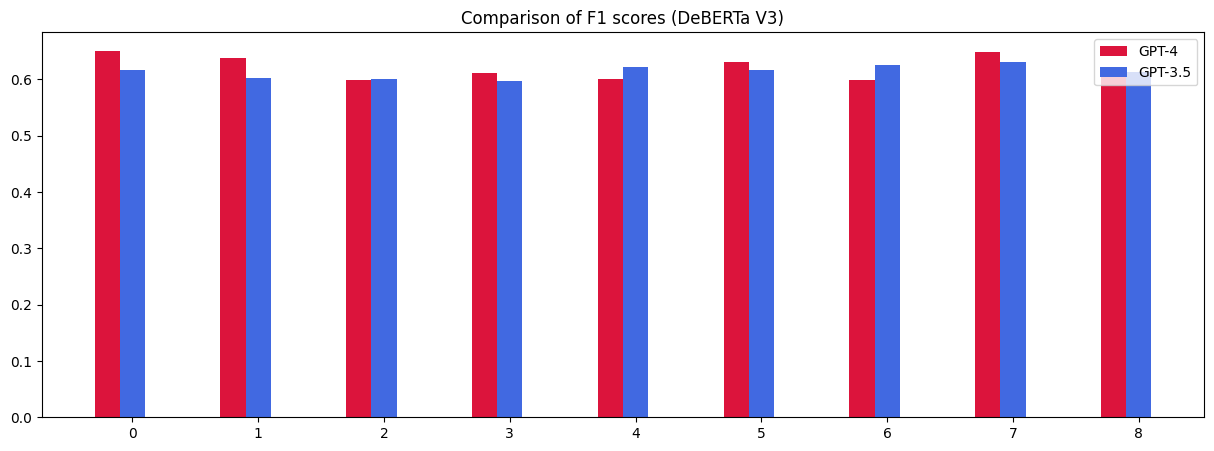

In [23]:
# Extract the F1 scores from the BERTScore results
f1_scores = results_deberta_v3_gpt4["f1"]
f1_scores_gpt_35 = results_deberta_v3_gpt35["f1"]

# Create a bar plot to visualize the F1 scores
fig, ax = plt.subplots(figsize=(15, 5))

width = 0.20
x = range(len(f1_scores))

# Plot the F1 scores for GPT-4
ax.bar(x, f1_scores, width, label='GPT-4', color='crimson')

# Plot the F1 scores for GPT-3.5
ax.bar([i + width for i in x], f1_scores_gpt_35, width, label='GPT-3.5', color='royalblue')

# Set the x-axis labels, title, and legend
ax.set_xticks([i + width / 2 for i in x])
ax.set_xticklabels([i for i in range(len(f1_scores))])
ax.set_title("Comparison of F1 scores (DeBERTa V3)")
ax.legend()

# Display the plot
plt.show()

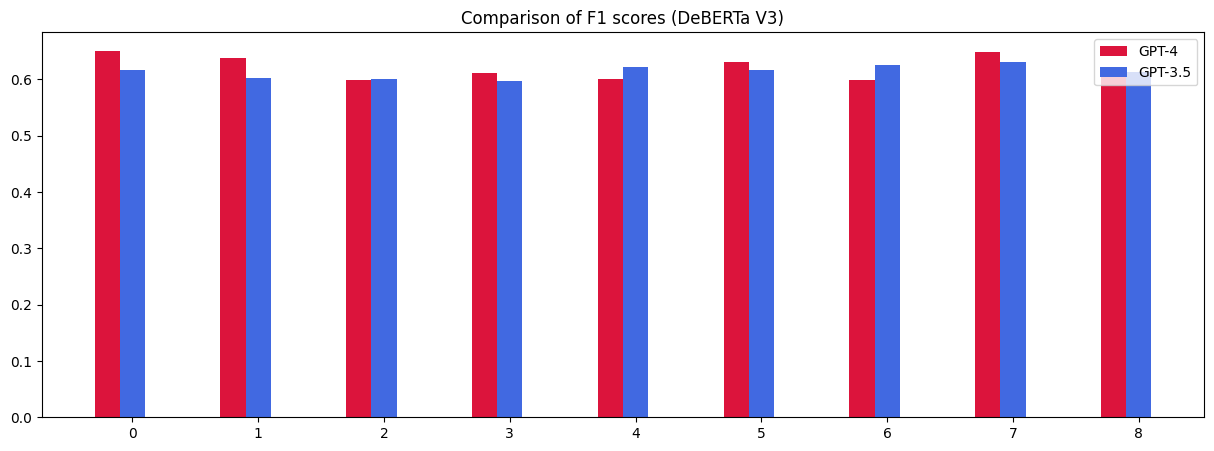

In [41]:
# Plot f1 score
f1_scores = results_deberta_v3_gpt4["f1"]
f1_scores_gpt_35 = results_deberta_v3_gpt35["f1"]

# plot

fig, ax = plt.subplots(figsize=(15, 5))

width = 0.20
x = range(len(f1_scores))

ax.bar(x, f1_scores, width, label='GPT-4', color='crimson')
ax.bar([i + width for i in x], f1_scores_gpt_35, width, label='GPT-3.5', color='royalblue')
ax.set_xticks([i + width for i in x])
ax.set_xticklabels([i for i in range(len(f1_scores))])
ax.set_title("Comparison of F1 scores (DeBERTa V3)")
ax.legend()

plt.show()

Now, the precision scores obtained from the ROUGE evaluations for both GPT-4 and GPT-3.5. This plot helps in comparing the performance of the two models.

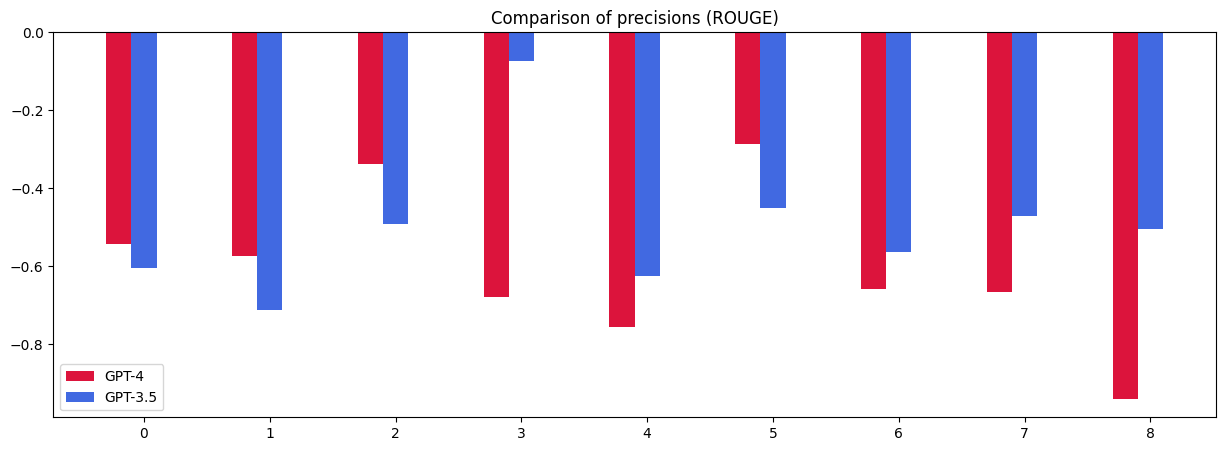

In [58]:
# Extract the precision scores from the ROUGE results
precisions_scores = results_gpt4['scores']
precisions_scores_gpt_35 = results_gpt_35['scores']

# Create a bar plot to visualize the precision scores
fig, ax = plt.subplots(figsize=(15, 5))

width = 0.20
x = range(len(precisions_scores))

# Plot the precision scores for GPT-4
ax.bar(x, precisions_scores, width, label='GPT-4', color='crimson')

# Plot the precision scores for GPT-3.5
ax.bar([i + width for i in x], precisions_scores_gpt_35, width, label='GPT-3.5', color='royalblue')

# Set the x-axis labels, title, and legend
ax.set_xticks([i + width / 2 for i in x])
ax.set_xticklabels([i for i in range(len(precisions_scores))])
ax.set_title("Comparison of Precision Scores (ROUGE)")
ax.legend()

# Display the plot
plt.show()

We use the BERTScore metric with the `allenai/longformer-large-4096-finetuned-triviaqa` model to evaluate the generated Protocol Plain Language Summaries (PPLS) from both GPT-4 and GPT-3.5. BERTScore provides a measure of similarity between the generated texts and the original texts.

In [43]:
# Compute BERTScore for the generated texts from GPT-4 using Longformer
results_longformer_gpt4 = bertscore.compute(
    predictions=texts_plain_gpt4, 
    references=texts_original, 
    model_type="allenai/longformer-large-4096-finetuned-triviaqa"
)

# Compute BERTScore for the generated texts from GPT-3.5 using Longformer
results_longformer_gpt35 = bertscore.compute(
    predictions=texts_plain_gpt_35, 
    references=texts_original, 
    model_type="allenai/longformer-large-4096-finetuned-triviaqa"
)

We visualize the F1 scores obtained from the BERTScore evaluations for both GPT-4 and GPT-3.5 using the `allenai/longformer-large-4096-finetuned-triviaqa` model. This plot helps in comparing the performance of the two models.

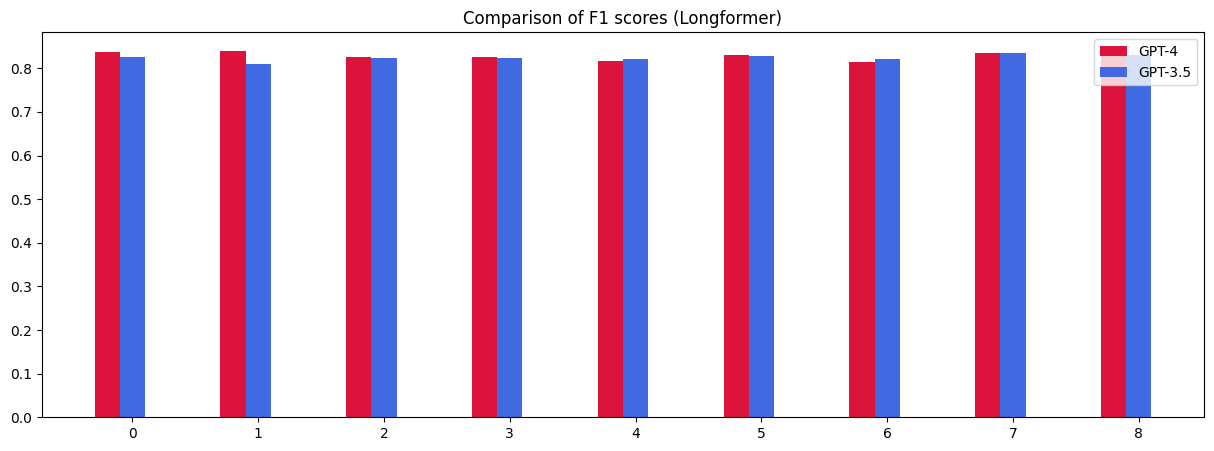

In [51]:
# Extract the F1 scores from the BERTScore results
f1_scores = results_longformer_gpt4["f1"]
f1_scores_gpt_35 = results_longformer_gpt35["f1"]

# Create a bar plot to visualize the F1 scores
fig, ax = plt.subplots(figsize=(15, 5))

width = 0.20
x = range(len(f1_scores))

# Plot the F1 scores for GPT-4
ax.bar(x, f1_scores, width, label='GPT-4', color='crimson')

# Plot the F1 scores for GPT-3.5
ax.bar([i + width for i in x], f1_scores_gpt_35, width, label='GPT-3.5', color='royalblue')

# Set the x-axis labels, title, and legend
ax.set_xticks([i + width / 2 for i in x])
ax.set_xticklabels([i for i in range(len(f1_scores))])
ax.set_title("Comparison of F1 Scores (Longformer)")
ax.legend()

# Display the plot
plt.show()

In [54]:
results_gpt4

{'precision': [0.6521058678627014,
  0.6643224954605103,
  0.6281422972679138,
  0.6145917177200317,
  0.6183218955993652,
  0.6424948573112488,
  0.6003948450088501,
  0.6473554968833923,
  0.618371307849884],
 'recall': [0.6366236209869385,
  0.6235613822937012,
  0.62086021900177,
  0.6096000671386719,
  0.6072510480880737,
  0.6156525611877441,
  0.5945109128952026,
  0.6336020827293396,
  0.6214134693145752],
 'f1': [0.6442717909812927,
  0.6432968974113464,
  0.6244800686836243,
  0.6120857000350952,
  0.6127364635467529,
  0.6287873387336731,
  0.597438395023346,
  0.6404049396514893,
  0.6198886632919312],
 'hashcode': 'facebook/bart-large-mnli_L11_no-idf_version=0.3.12(hug_trans=4.27.0.dev0)'}

In [55]:
results_gpt_35

{'precision': [0.6434116959571838,
  0.6135786175727844,
  0.6343647241592407,
  0.6060109734535217,
  0.6336561441421509,
  0.6496988534927368,
  0.6295475363731384,
  0.6321994662284851,
  0.6382576823234558],
 'recall': [0.5967025756835938,
  0.5994625091552734,
  0.6074342727661133,
  0.6039993166923523,
  0.6055898070335388,
  0.5703374147415161,
  0.602471649646759,
  0.6260007619857788,
  0.5993726253509521],
 'f1': [0.619177520275116,
  0.6064384579658508,
  0.6206074953079224,
  0.6050034761428833,
  0.6193051934242249,
  0.6074369549751282,
  0.61571204662323,
  0.6290848851203918,
  0.6182042360305786],
 'hashcode': 'facebook/bart-large-mnli_L11_no-idf_version=0.3.12(hug_trans=4.27.0.dev0)'}

In [56]:
results_deberta_v3_gpt35

{'precision': [0.6462053656578064,
  0.6053144335746765,
  0.6204533576965332,
  0.6099984645843506,
  0.64338618516922,
  0.6711529493331909,
  0.645161509513855,
  0.6248485445976257,
  0.6457805633544922],
 'recall': [0.5897459983825684,
  0.5987589359283447,
  0.5825722217559814,
  0.5854591727256775,
  0.6007969379425049,
  0.570181667804718,
  0.6058452725410461,
  0.6371961832046509,
  0.583759069442749],
 'f1': [0.6166861057281494,
  0.6020188331604004,
  0.6009163856506348,
  0.5974768996238708,
  0.6213626265525818,
  0.616560697555542,
  0.6248855590820312,
  0.6309619545936584,
  0.6132055521011353],
 'hashcode': 'microsoft/deberta-v3-base_L9_no-idf_version=0.3.12(hug_trans=4.27.0.dev0)'}

In [57]:
results_deberta_v3_gpt4

{'precision': [0.6564638614654541,
  0.6562505960464478,
  0.6108186841011047,
  0.6227301359176636,
  0.6037321090698242,
  0.6541074514389038,
  0.6093407869338989,
  0.6502459645271301,
  0.6297975778579712],
 'recall': [0.6455540060997009,
  0.6192583441734314,
  0.5882319211959839,
  0.6009960174560547,
  0.5980139374732971,
  0.6075593829154968,
  0.5883185267448425,
  0.645451545715332,
  0.6155847907066345],
 'f1': [0.6509631872177124,
  0.6372181177139282,
  0.5993125438690186,
  0.6116700768470764,
  0.6008594036102295,
  0.6299747824668884,
  0.5986452102661133,
  0.6478399038314819,
  0.6226101517677307],
 'hashcode': 'microsoft/deberta-v3-base_L9_no-idf_version=0.3.12(hug_trans=4.27.0.dev0)'}

In [58]:
results_longformer_gpt35

{'precision': [0.8333979249000549,
  0.8064426779747009,
  0.8295961618423462,
  0.8323920965194702,
  0.8292905688285828,
  0.8503139019012451,
  0.8240782618522644,
  0.8388121128082275,
  0.843914270401001],
 'recall': [0.8168718814849854,
  0.8134331107139587,
  0.8173574805259705,
  0.8145012855529785,
  0.8110893964767456,
  0.8055998682975769,
  0.8182771801948547,
  0.8319569826126099,
  0.8191688060760498],
 'f1': [0.8250522017478943,
  0.8099228739738464,
  0.8234313726425171,
  0.8233494758605957,
  0.8200889825820923,
  0.8273531198501587,
  0.8211674690246582,
  0.8353704810142517,
  0.831357479095459],
 'hashcode': 'allenai/longformer-large-4096-finetuned-triviaqa_L14_no-idf_version=0.3.12(hug_trans=4.27.0.dev0)'}

In [59]:
results_longformer_gpt4

{'precision': [0.8425096273422241,
  0.8510268926620483,
  0.8270114660263062,
  0.833105206489563,
  0.8274542689323425,
  0.8413091897964478,
  0.8162148594856262,
  0.8387017250061035,
  0.8289621472358704],
 'recall': [0.8326307535171509,
  0.8300791382789612,
  0.8257637023925781,
  0.8195526599884033,
  0.808257520198822,
  0.8218235373497009,
  0.811801552772522,
  0.8303934335708618,
  0.8255344033241272],
 'f1': [0.8375410437583923,
  0.8404224514961243,
  0.8263871073722839,
  0.8262733817100525,
  0.8177432417869568,
  0.8314522504806519,
  0.8140022158622742,
  0.8345268964767456,
  0.827244758605957],
 'hashcode': 'allenai/longformer-large-4096-finetuned-triviaqa_L14_no-idf_version=0.3.12(hug_trans=4.27.0.dev0)'}